In [ ]:
5

=== Running experiments with symmetric noise ===
Using cpu device

=== Running experiment with noise rate: 0.2 ===


Training with standard Cross-Entropy loss
[1, 200] loss: 1.959
[2, 200] loss: 1.663
[3, 200] loss: 1.515
Accuracy on clean test images: 68.62%

Training with Normalized Cross-Entropy loss
[1, 200] loss: 1.957
[2, 200] loss: 1.651
[3, 200] loss: 1.532
Accuracy on clean test images: 68.32%

Training with Focal Loss
[1, 200] loss: 1.958
[2, 200] loss: 1.656
[3, 200] loss: 1.528
Accuracy on clean test images: 66.78%

Training with Normalized Focal Loss
[1, 200] loss: 1.484
[2, 200] loss: 1.201
[3, 200] loss: 1.090
Accuracy on clean test images: 64.45%

Training with APL (NCE + MAE)
[1, 200] loss: 3.574
[2, 200] loss: 2.991
[3, 200] loss: 2.725
Accuracy on clean test images: 69.22%

Training with APL (NFL + RCE)
[1, 200] loss: 8.750
[2, 200] loss: 7.176
[3, 200] loss: 6.448
Accuracy on clean test images: 69.30%

=== Running experiment with noise rate: 0.4 ===


Training with 

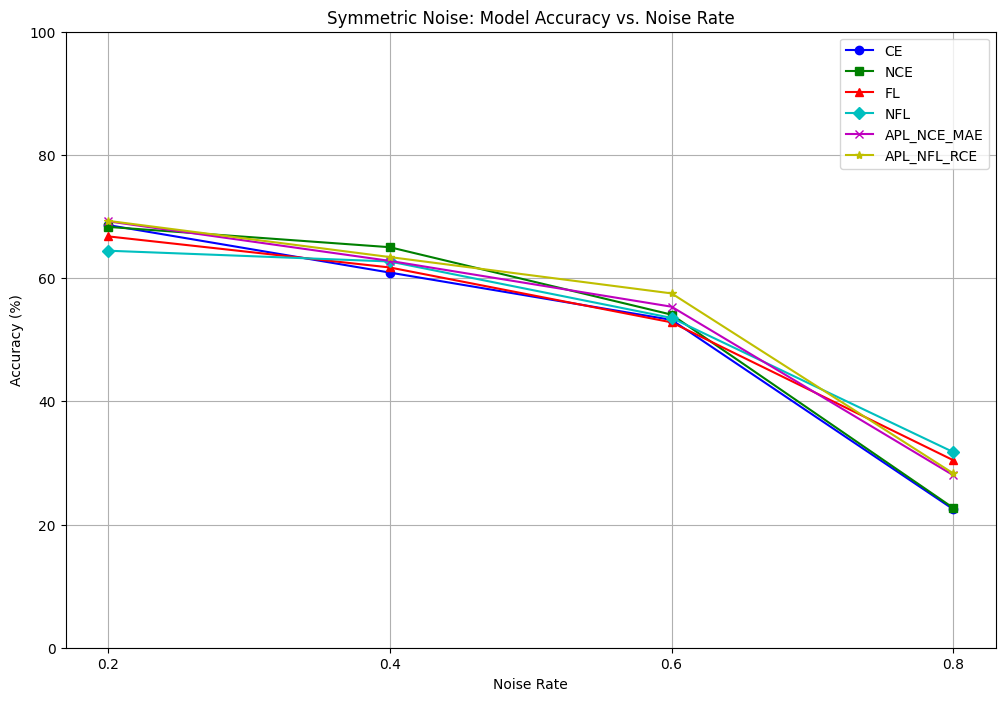

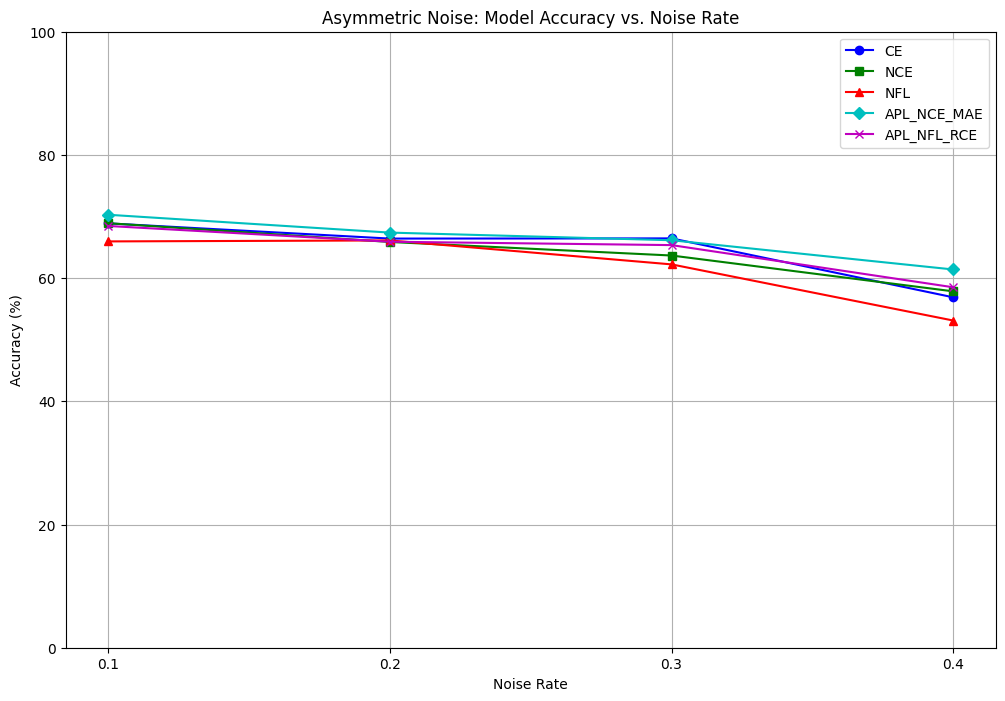

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.nn import functional as F
import copy

def add_symmetric_noise(cifar_dataset, noise_rate):
    """
    Introduce symmetric noise to CIFAR-10 dataset by randomly flipping labels

    Args:
        cifar_dataset: CIFAR-10 dataset
        noise_rate: probability of flipping a label

    Returns:
        Dataset with noisy labels
    """
    dataset_with_noisy_labels = copy.deepcopy(cifar_dataset)
    num_classes = 10

    original_labels = np.array(cifar_dataset.targets) if isinstance(cifar_dataset.targets, list) else cifar_dataset.targets.numpy()

    num_samples = len(original_labels)

    indices_to_flip = np.random.rand(num_samples) < noise_rate

    for idx in np.where(indices_to_flip)[0]:
        original_label = original_labels[idx]
        possible_labels = list(range(num_classes))
        possible_labels.remove(original_label)
        original_labels[idx] = np.random.choice(possible_labels)

    dataset_with_noisy_labels.targets = torch.tensor(original_labels)

    return dataset_with_noisy_labels

class NormalizedCrossEntropy(nn.Module):
    def __init__(self, num_classes=10):
        super(NormalizedCrossEntropy, self).__init__()
        self.num_classes = num_classes

    def forward(self, predictions, labels):
        predictions = F.softmax(predictions, dim=1)
        predictions = torch.clamp(predictions, min=1e-7, max=1.0)
        label_one_hot = F.one_hot(labels, self.num_classes).float()
        nce = -torch.mean(torch.sum(label_one_hot * torch.log(predictions), dim=1))
        return nce

class NormalizedFocalLoss(nn.Module):
    def __init__(self, gamma=2, num_classes=10):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = F.one_hot(labels, self.num_classes).float()
        weight = torch.pow(1 - pred, self.gamma)
        focal = -torch.sum(weight * label_one_hot * torch.log(pred), dim=1)
        return torch.mean(focal)

class MeanAbsoluteError(nn.Module):
    def __init__(self, num_classes=10):
        super(MeanAbsoluteError, self).__init__()
        self.num_classes = num_classes

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = F.one_hot(labels, self.num_classes).float()
        mae = torch.sum(torch.abs(pred - label_one_hot), dim=1)
        return torch.mean(mae)

class ReverseCrossEntropy(nn.Module):
    def __init__(self, num_classes=10):
        super(ReverseCrossEntropy, self).__init__()
        self.num_classes = num_classes

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = F.one_hot(labels, self.num_classes).float()
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = -torch.mean(torch.sum(pred * torch.log(label_one_hot), dim=1))
        return rce

class ActivePassiveLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, active_loss='nce', passive_loss='mae', num_classes=10):
        super(ActivePassiveLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

        # Active losses
        if active_loss == 'nce':
            self.active_loss = NormalizedCrossEntropy(num_classes)
        elif active_loss == 'nfl':
            self.active_loss = NormalizedFocalLoss(num_classes=num_classes)
        else:
            raise ValueError(f"Unsupported active loss: {active_loss}")

        # Passive losses
        if passive_loss == 'mae':
            self.passive_loss = MeanAbsoluteError(num_classes)
        elif passive_loss == 'rce':
            self.passive_loss = ReverseCrossEntropy(num_classes)
        else:
            raise ValueError(f"Unsupported passive loss: {passive_loss}")

    def forward(self, pred, labels):
        active_loss = self.active_loss(pred, labels)
        passive_loss = self.passive_loss(pred, labels)
        return self.alpha * active_loss + self.beta * passive_loss

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_model(model, trainloader, criterion, optimizer, device, epochs=5):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 200 == 199:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}')
                train_losses.append(running_loss / 200)
                running_loss = 0.0

    return train_losses

def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on clean test images: {accuracy:.2f}%')
    return accuracy

def run_experiment(noise_rates=[0.2, 0.4, 0.6, 0.8], batch_size=128, lr=0.001, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)

    testloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    results = {
        'CE': [],
        'NCE': [],
        'FL': [],
        'NFL': [],
        'APL_NCE_MAE': [],
        'APL_NFL_RCE': []
    }

    for noise_rate in noise_rates:
        print(f"\n=== Running experiment with noise rate: {noise_rate} ===\n")

        noisy_train_dataset = add_symmetric_noise(train_dataset, noise_rate)

        trainloader = torch.utils.data.DataLoader(
            noisy_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

        print("\nTraining with standard Cross-Entropy loss")
        model_ce = SimpleCNN().to(device)
        criterion_ce = nn.CrossEntropyLoss()
        optimizer_ce = optim.Adam(model_ce.parameters(), lr=lr)
        train_model(model_ce, trainloader, criterion_ce, optimizer_ce, device, epochs=epochs)
        acc_ce = evaluate_model(model_ce, testloader, device)
        results['CE'].append(acc_ce)

        print("\nTraining with Normalized Cross-Entropy loss")
        model_nce = SimpleCNN().to(device)
        criterion_nce = NormalizedCrossEntropy()
        optimizer_nce = optim.Adam(model_nce.parameters(), lr=lr)
        train_model(model_nce, trainloader, criterion_nce, optimizer_nce, device, epochs=epochs)
        acc_nce = evaluate_model(model_nce, testloader, device)
        results['NCE'].append(acc_nce)

        print("\nTraining with Focal Loss")
        model_fl = SimpleCNN().to(device)
        criterion_fl = nn.CrossEntropyLoss()
        optimizer_fl = optim.Adam(model_fl.parameters(), lr=lr)
        train_model(model_fl, trainloader, criterion_fl, optimizer_fl, device, epochs=epochs)
        acc_fl = evaluate_model(model_fl, testloader, device)
        results['FL'].append(acc_fl)

        print("\nTraining with Normalized Focal Loss")
        model_nfl = SimpleCNN().to(device)
        criterion_nfl = NormalizedFocalLoss()
        optimizer_nfl = optim.Adam(model_nfl.parameters(), lr=lr)
        train_model(model_nfl, trainloader, criterion_nfl, optimizer_nfl, device, epochs=epochs)
        acc_nfl = evaluate_model(model_nfl, testloader, device)
        results['NFL'].append(acc_nfl)

        # APL: NCE + MAE
        print("\nTraining with APL (NCE + MAE)")
        model_apl_nce_mae = SimpleCNN().to(device)
        criterion_apl_nce_mae = ActivePassiveLoss(active_loss='nce', passive_loss='mae')
        optimizer_apl_nce_mae = optim.Adam(model_apl_nce_mae.parameters(), lr=lr)
        train_model(model_apl_nce_mae, trainloader, criterion_apl_nce_mae,
                   optimizer_apl_nce_mae, device, epochs=epochs)
        acc_apl_nce_mae = evaluate_model(model_apl_nce_mae, testloader, device)
        results['APL_NCE_MAE'].append(acc_apl_nce_mae)

        # APL: NFL + RCE
        print("\nTraining with APL (NFL + RCE)")
        model_apl_nfl_rce = SimpleCNN().to(device)
        criterion_apl_nfl_rce = ActivePassiveLoss(active_loss='nfl', passive_loss='rce')
        optimizer_apl_nfl_rce = optim.Adam(model_apl_nfl_rce.parameters(), lr=lr)
        train_model(model_apl_nfl_rce, trainloader, criterion_apl_nfl_rce,
                   optimizer_apl_nfl_rce, device, epochs=epochs)
        acc_apl_nfl_rce = evaluate_model(model_apl_nfl_rce, testloader, device)
        results['APL_NFL_RCE'].append(acc_apl_nfl_rce)

    return results, noise_rates

def add_asymmetric_noise(dataset, noise_rate):
    """
    Introduce asymmetric noise to CIFAR-10 dataset
    Asymmetric noise flips labels in a more structured way (e.g., car→truck, bird→airplane)

    Args:
        dataset: CIFAR-10 dataset
        noise_rate: probability of flipping a label

    Returns:
        Dataset with noisy labels
    """
    noisy_dataset = copy.deepcopy(dataset)

    class_map = {
        0: 2,  # airplane → bird
        1: 9,  # automobile → truck
        2: 0,  # bird → airplane
        3: 5,  # cat → dog
        4: 7,  # deer → horse
        5: 3,  # dog → cat
        6: 4,  # frog → deer
        7: 4,  # horse → deer
        8: 9,  # ship → truck
        9: 1,  # truck → automobile
    }

    if isinstance(dataset.targets, list):
        targets = np.array(dataset.targets)
    else:
        targets = dataset.targets.numpy()

    for i in range(10):
        idx = np.where(targets == i)[0]
        n_samples = len(idx)
        n_flip = int(noise_rate * n_samples)
        flip_idx = np.random.choice(idx, n_flip, replace=False)
        targets[flip_idx] = class_map[i]

    noisy_dataset.targets = torch.tensor(targets)

    return noisy_dataset

def run_bonus_experiment(noise_rates=[0.1, 0.2, 0.3, 0.4], batch_size=128, lr=0.001, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)

    testloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    results = {
        'CE': [],
        'NCE': [],
        'NFL': [],
        'APL_NCE_MAE': [],
        'APL_NFL_RCE': []
    }

    for noise_rate in noise_rates:
        print(f"\n=== Running BONUS experiment with asymmetric noise rate: {noise_rate} ===\n")

        noisy_train_dataset = add_asymmetric_noise(train_dataset, noise_rate)

        trainloader = torch.utils.data.DataLoader(
            noisy_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

        # Standard Cross-Entropy
        print("\nTraining with standard Cross-Entropy loss")
        model_ce = SimpleCNN().to(device)
        criterion_ce = nn.CrossEntropyLoss()
        optimizer_ce = optim.Adam(model_ce.parameters(), lr=lr)
        train_model(model_ce, trainloader, criterion_ce, optimizer_ce, device, epochs=epochs)
        acc_ce = evaluate_model(model_ce, testloader, device)
        results['CE'].append(acc_ce)

        # Normalized Cross-Entropy
        print("\nTraining with Normalized Cross-Entropy loss")
        model_nce = SimpleCNN().to(device)
        criterion_nce = NormalizedCrossEntropy()
        optimizer_nce = optim.Adam(model_nce.parameters(), lr=lr)
        train_model(model_nce, trainloader, criterion_nce, optimizer_nce, device, epochs=epochs)
        acc_nce = evaluate_model(model_nce, testloader, device)
        results['NCE'].append(acc_nce)

        # Normalized Focal Loss
        print("\nTraining with Normalized Focal Loss")
        model_nfl = SimpleCNN().to(device)
        criterion_nfl = NormalizedFocalLoss()
        optimizer_nfl = optim.Adam(model_nfl.parameters(), lr=lr)
        train_model(model_nfl, trainloader, criterion_nfl, optimizer_nfl, device, epochs=epochs)
        acc_nfl = evaluate_model(model_nfl, testloader, device)
        results['NFL'].append(acc_nfl)

        # APL: NCE + MAE
        print("\nTraining with APL (NCE + MAE)")
        model_apl_nce_mae = SimpleCNN().to(device)
        criterion_apl_nce_mae = ActivePassiveLoss(active_loss='nce', passive_loss='mae')
        optimizer_apl_nce_mae = optim.Adam(model_apl_nce_mae.parameters(), lr=lr)
        train_model(model_apl_nce_mae, trainloader, criterion_apl_nce_mae,
                   optimizer_apl_nce_mae, device, epochs=epochs)
        acc_apl_nce_mae = evaluate_model(model_apl_nce_mae, testloader, device)
        results['APL_NCE_MAE'].append(acc_apl_nce_mae)

        # APL: NFL + RCE
        print("\nTraining with APL (NFL + RCE)")
        model_apl_nfl_rce = SimpleCNN().to(device)
        criterion_apl_nfl_rce = ActivePassiveLoss(active_loss='nfl', passive_loss='rce')
        optimizer_apl_nfl_rce = optim.Adam(model_apl_nfl_rce.parameters(), lr=lr)
        train_model(model_apl_nfl_rce, trainloader, criterion_apl_nfl_rce,
                   optimizer_apl_nfl_rce, device, epochs=epochs)
        acc_apl_nfl_rce = evaluate_model(model_apl_nfl_rce, testloader, device)
        results['APL_NFL_RCE'].append(acc_apl_nfl_rce)

    return results, noise_rates

def plot_results(results, noise_rates, title_prefix="Symmetric"):
    plt.figure(figsize=(12, 8))

    markers = ['o', 's', '^', 'D', 'x', '*']
    colors = ['b', 'g', 'r', 'c', 'm', 'y']

    for i, (method, accuracies) in enumerate(results.items()):
        plt.plot(noise_rates, accuracies, marker=markers[i % len(markers)],
                 color=colors[i % len(colors)], label=method)

    plt.title(f'{title_prefix} Noise: Model Accuracy vs. Noise Rate')
    plt.xlabel('Noise Rate')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.xticks(noise_rates)
    plt.ylim(0, 100)

    return plt

def main():
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    symmetric_noise_rates = [0.2, 0.4, 0.6, 0.8]
    asymmetric_noise_rates = [0.1, 0.2, 0.3, 0.4]

    batch_size = 128
    epochs = 3

    print("=== Running experiments with symmetric noise ===")
    sym_results, sym_noise_rates = run_experiment(
        noise_rates=symmetric_noise_rates,
        batch_size=batch_size,
        epochs=epochs
    )

    sym_plot = plot_results(sym_results, sym_noise_rates, "Symmetric")
    sym_plot.savefig('symmetric_noise_results.png')
    print("Symmetric noise results saved as 'symmetric_noise_results.png'")

    print("\n=== Running BONUS experiments with asymmetric noise ===")
    asym_results, asym_noise_rates = run_bonus_experiment(
        noise_rates=asymmetric_noise_rates,
        batch_size=batch_size,
        epochs=epochs
    )

    asym_plot = plot_results(asym_results, asym_noise_rates, "Asymmetric")
    asym_plot.savefig('asymmetric_noise_results.png')
    print("Asymmetric noise results saved as 'asymmetric_noise_results.png'")

    print("\nExperiments completed. Results saved as PNG files")

if __name__ == "__main__":
    main()